In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

### Load session and complete climb data

In [39]:
sessions = pd.read_csv('raw_data/5513-climb-session-export-2024-03-12T20-19-09.csv')
climbs = pd.read_csv('raw_data/5513-climb-export-2024-03-12T20-19-09.csv')

In [40]:
climbs.head()

,Session ID,Time,Discipline,Grade,Attempt,Grade System,Heart Rate,Notes
0,7.319011e+08,2024-03-11 18:54:46,Boulder,V0,False,hueco,0.0,NaN
1,7.319011e+08,2024-03-11 18:56:01,Boulder,V2,False,hueco,0.0,NaN
2,7.319011e+08,2024-03-11 18:58:31,Boulder,V3,True,hueco,0.0,NaN
3,7.319011e+08,2024-03-11 18:59:44,Boulder,V1,False,hueco,0.0,NaN
4,7.319011e+08,2024-03-11 19:01:04,Boulder,V3,False,hueco,0.0,NaN


### Progress per bouldering grade

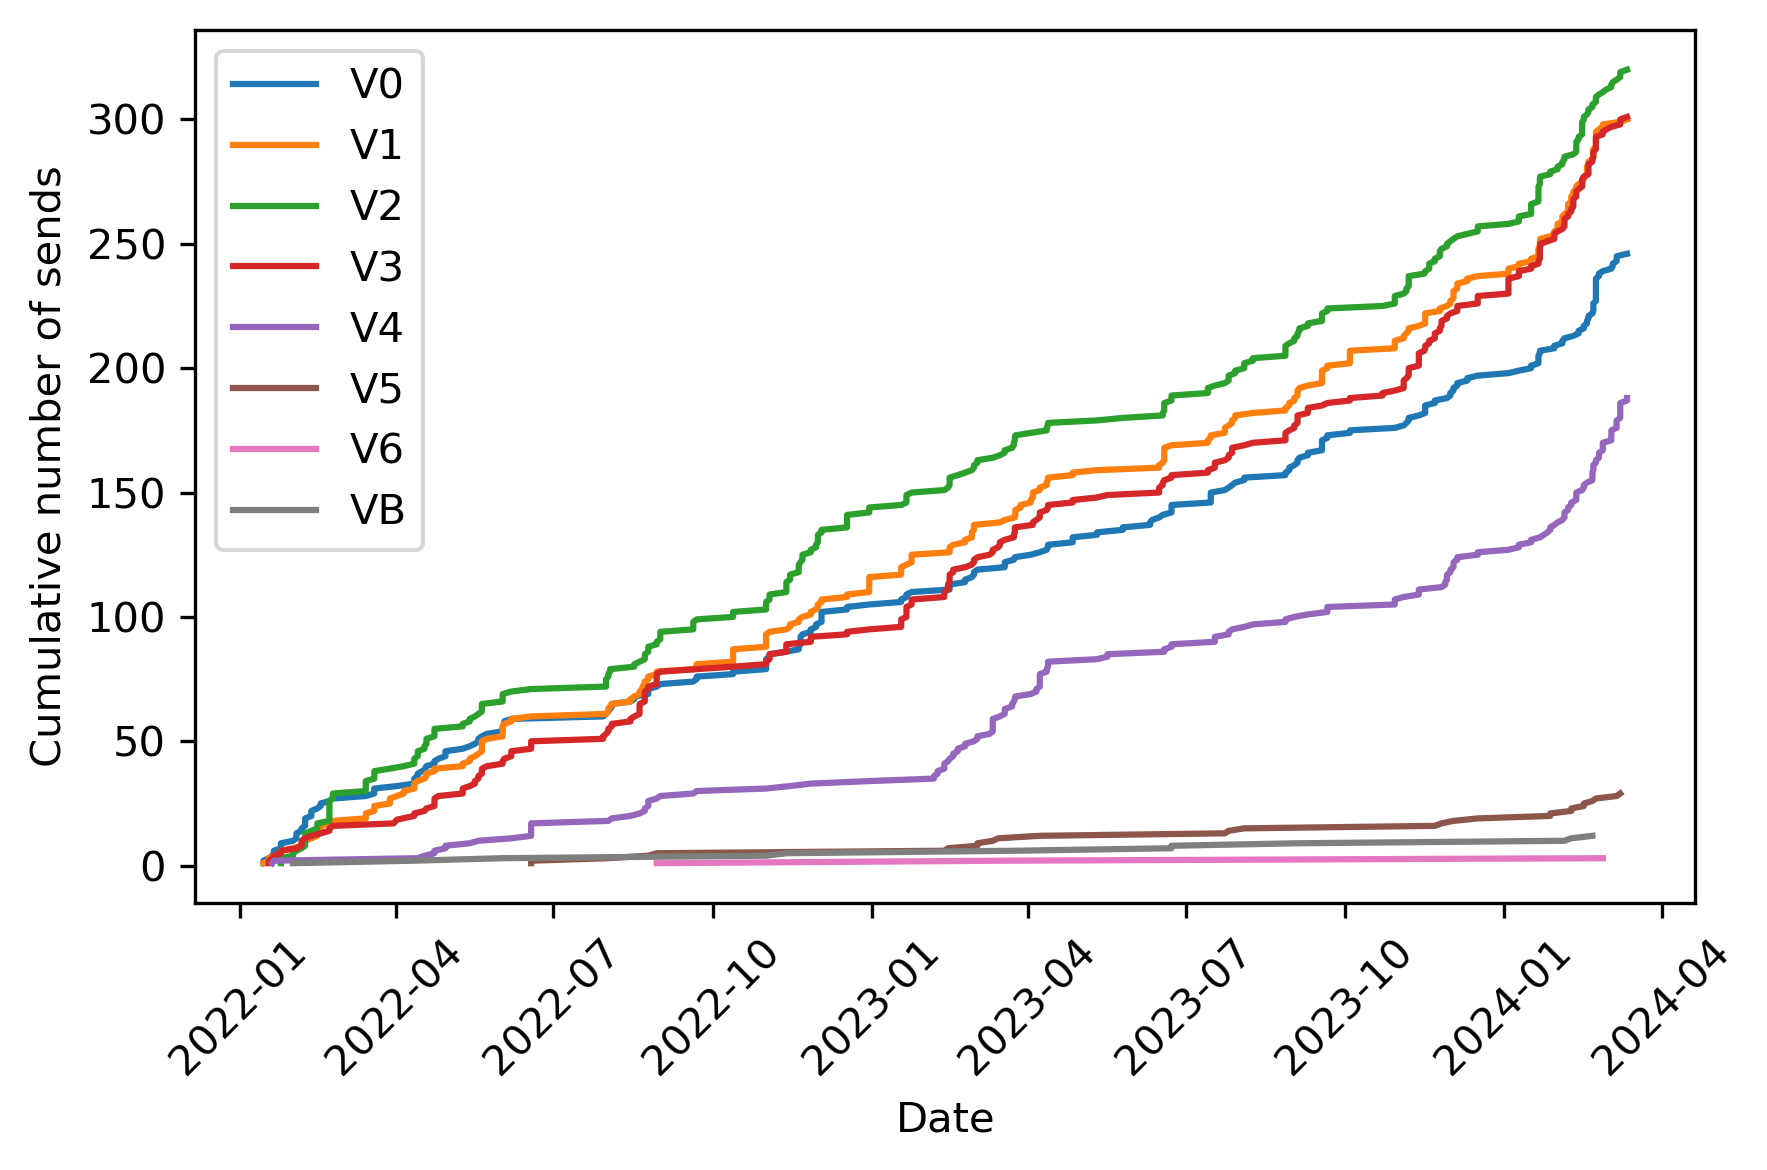

In [41]:
# subset bouldering data only 
boulders = climbs[climbs['Discipline'] == 'Boulder']

grouped_levels = {}
for level, group in boulders.groupby('Grade'):
    grouped_levels[level] = group

sends = {}
for level, group_df in grouped_levels.items():
    sends[level] = group_df[group_df['Attempt'] == False]

plt.figure(figsize=(6, 4),dpi=300)
chosen_palette = sns.color_palette("rocket")

for level, filtered_df in sends.items():
    filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])  
    filtered_df = filtered_df.sort_values(by='Time') 
    filtered_df['Cumulative'] = range(1, len(filtered_df) + 1) 
    sns.lineplot(x='Time', y='Cumulative', data=filtered_df,label=level)
    plt.xlabel('Date')
    plt.ylabel('Cumulative number of sends')
    plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# Proportion of a given grade over monthly total

In [42]:
def normalize_counts_by_total(df, grade_numeric):
    """
    Normalize the counts by all climbs in a given quarterly period.

    Parameters:
    - df: DataFrame with sends data.
    - grade_numeric: The numeric value of the grade to filter on or above.

    Returns:
    - DataFrame with normalized counts for each 3-month period.
    """
    filtered = df[df['NumericLevel'] >= grade_numeric]
    filtered_resampled = filtered.resample('Q')['NumericLevel'].count().to_frame(name=f'Counts_Grade_{grade_numeric}_or_higher')
    total_counts_resampled = df.resample('Q')['NumericLevel'].count().to_frame(name='Total_Counts')
    normalized_counts = filtered_resampled.div(total_counts_resampled['Total_Counts'], axis=0)
    return normalized_counts


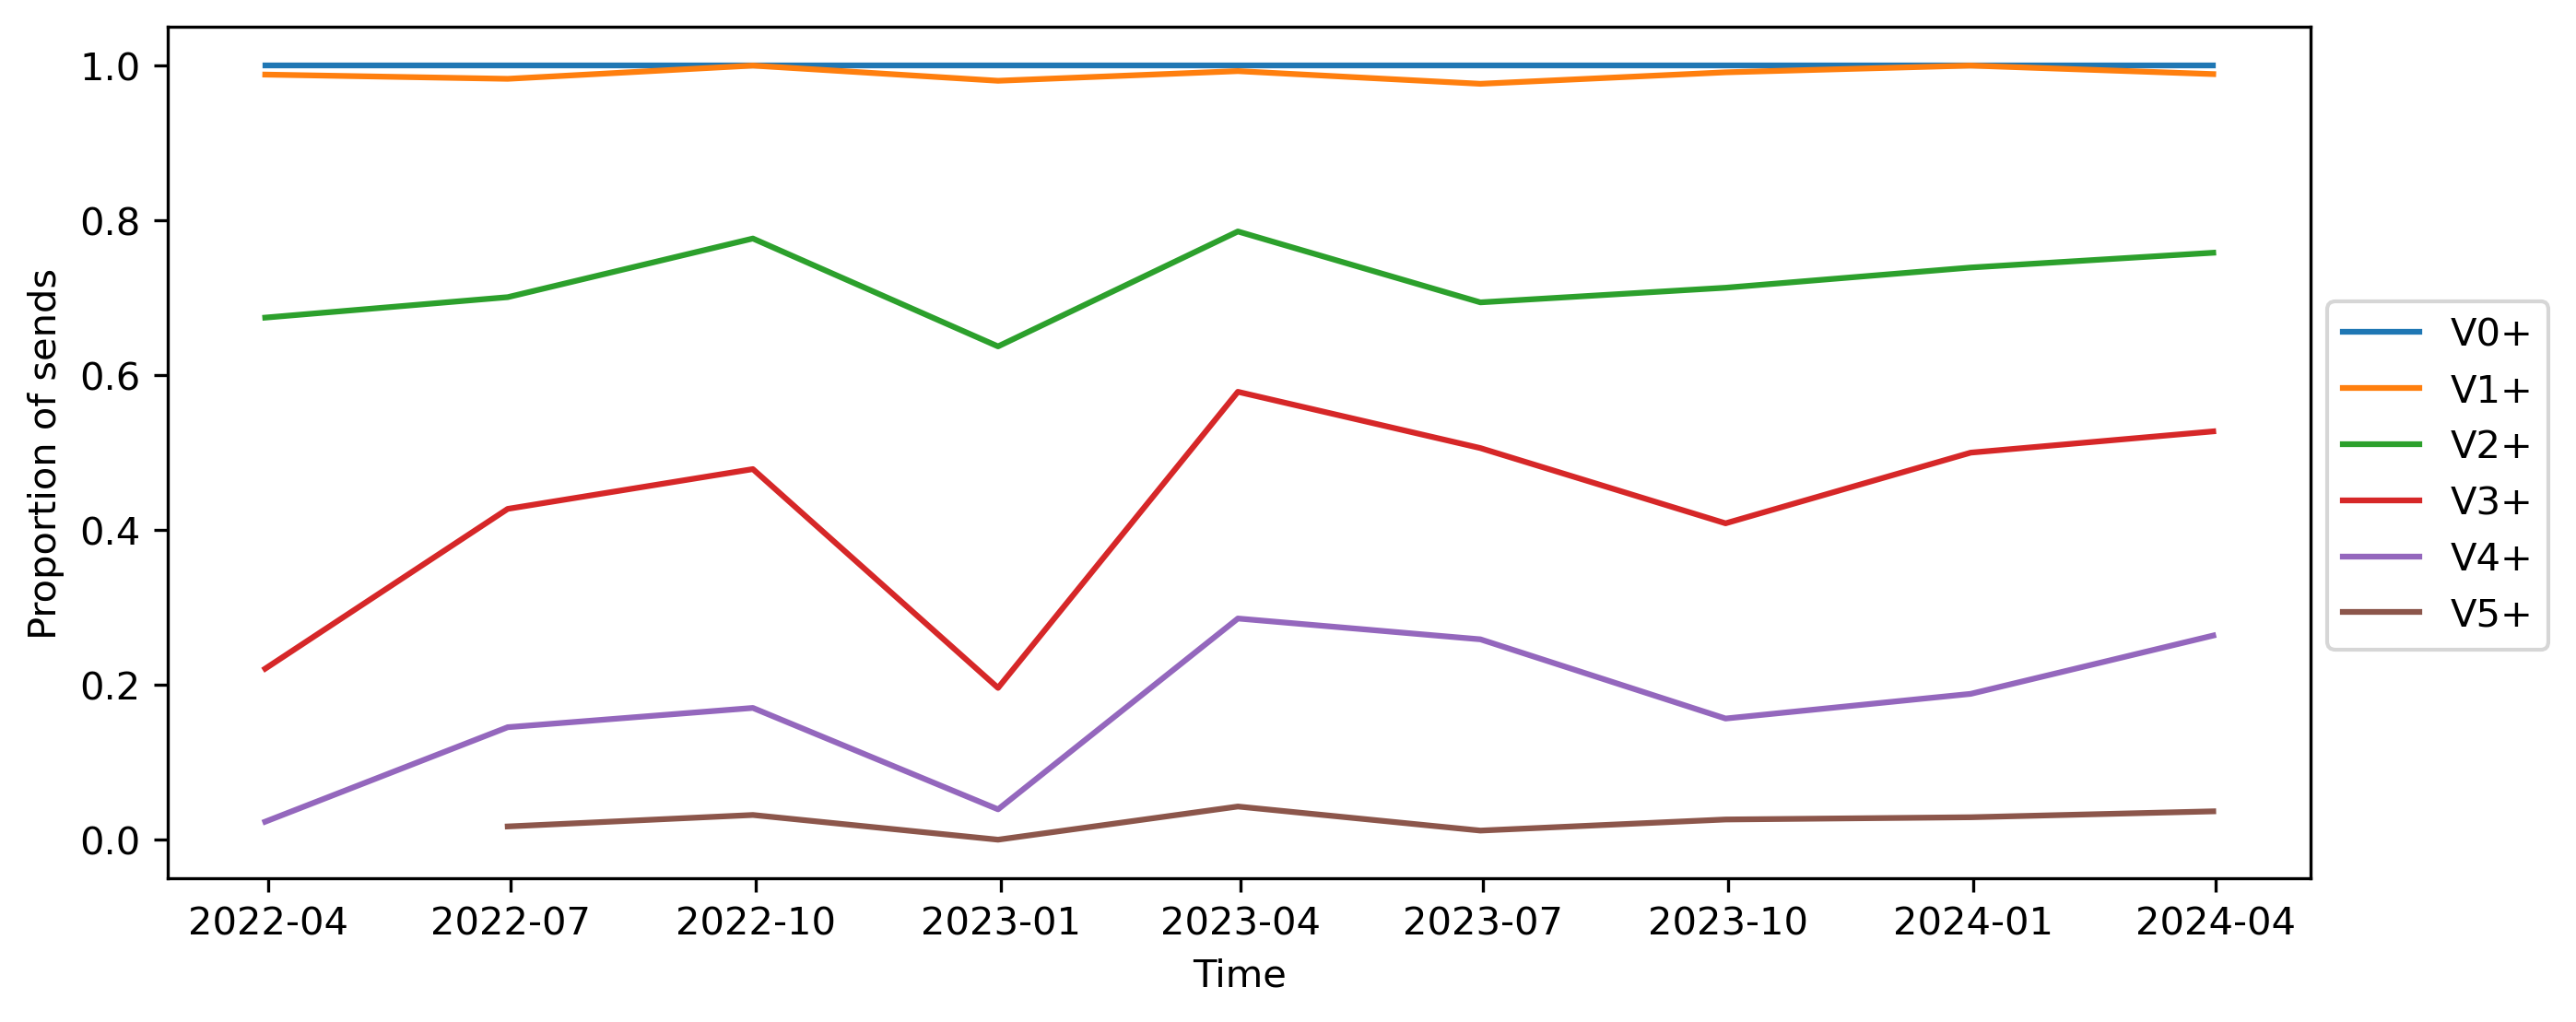

In [43]:
sends = boulders[boulders['Attempt'] == False]
sends['Time'] = pd.to_datetime(sends['Time'])
sends.set_index('Time', inplace=True)

grade_scale = {'VB': 1, 'V1': 2, 'V2': 3, 'V3': 4, 'V4': 5, 'V5': 6}
sends['NumericLevel'] = sends['Grade'].map(grade_scale)

plt.figure(figsize=(10, 4), dpi=300)
ax = plt.gca()

for grade, numeric_value in grade_scale.items():
    if grade != 'V6':
        normalized_counts = normalize_counts_by_total(sends, numeric_value)
        line = ax.plot(normalized_counts.index, normalized_counts.values, label=f'V{grade_scale[grade]-1}+')[0]

plt.legend(bbox_to_anchor=(1.12, 0.7), loc='upper right')
plt.xlabel('Time')
plt.ylabel('Proportion of sends')
plt.show()

### Progress in top rope

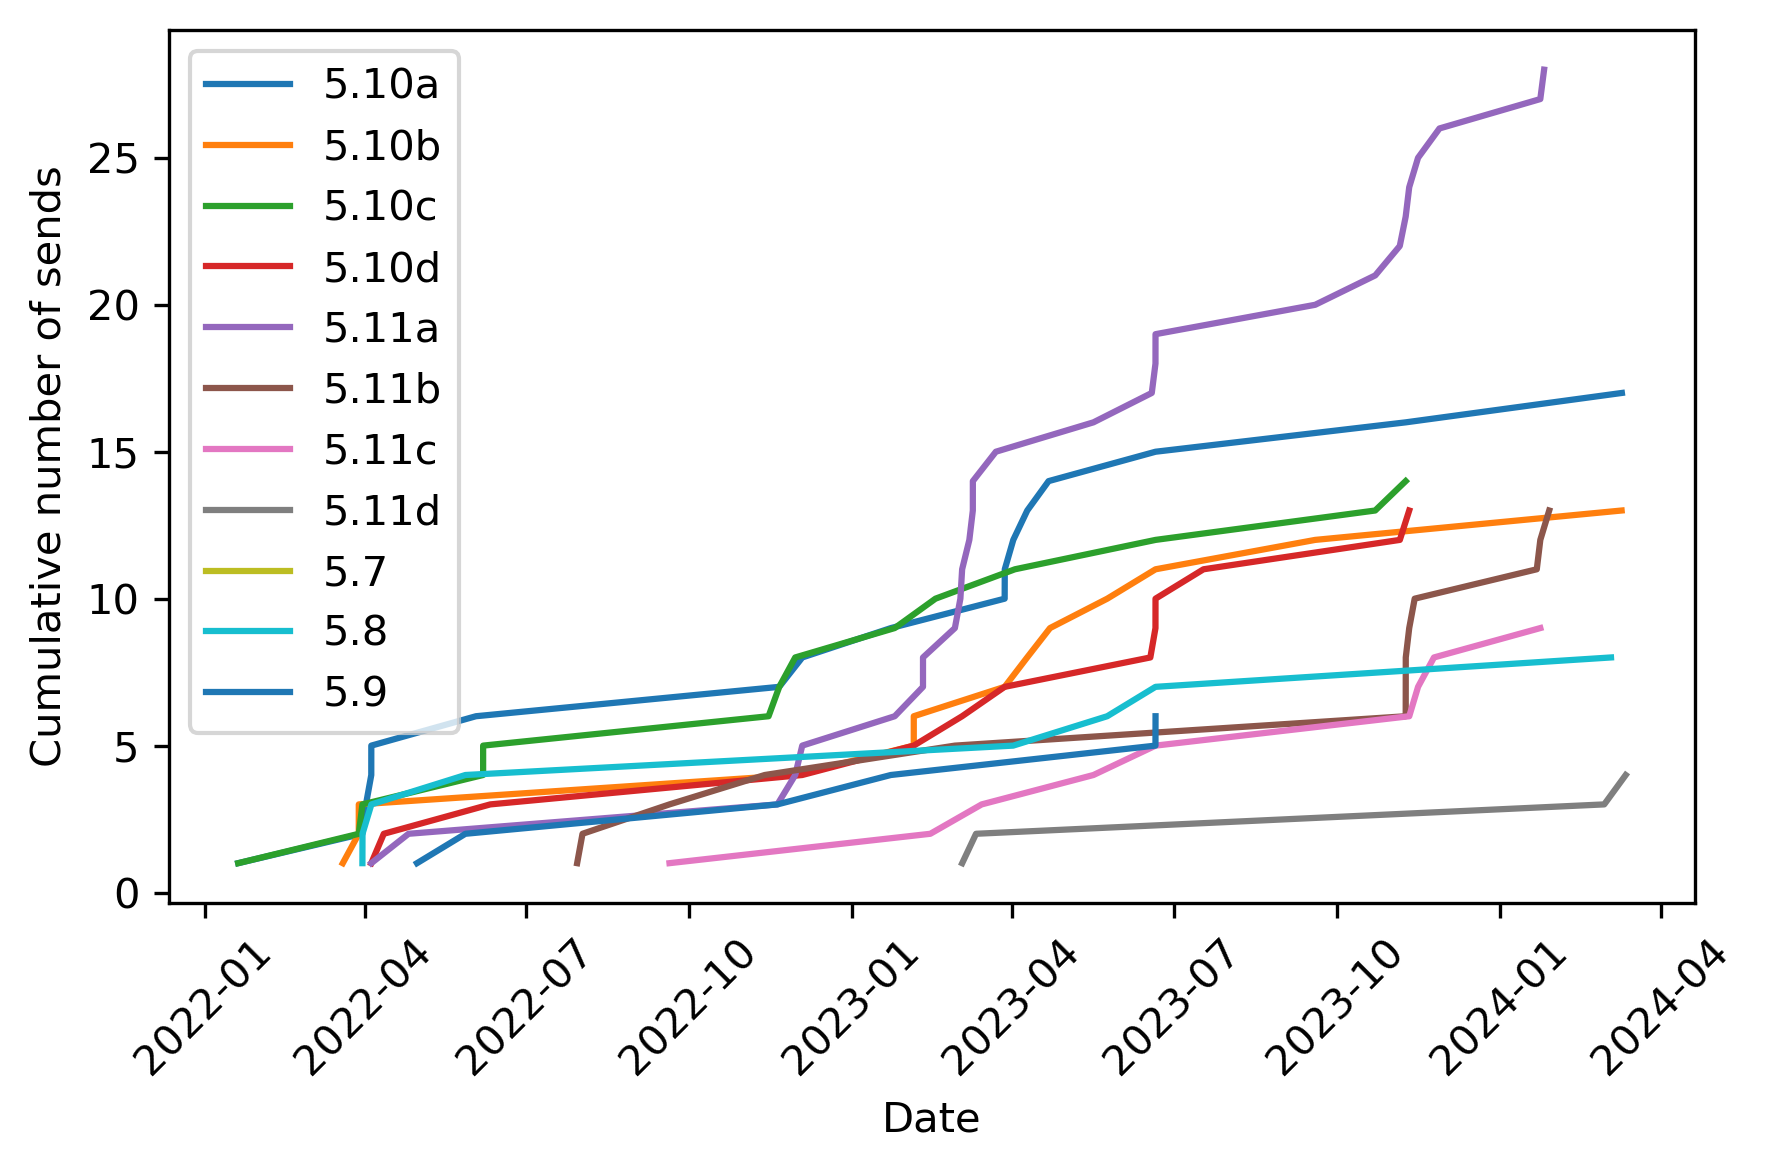

In [44]:
# subset bouldering data only 
TR = climbs[climbs['Discipline'] == 'Top Rope']

grouped_levels = {}
for level, group in TR.groupby('Grade'):
    grouped_levels[level] = group

sends = {}
for level, group_df in grouped_levels.items():
    sends[level] = group_df[group_df['Attempt'] == False]

plt.figure(figsize=(6, 4),dpi=300)
chosen_palette = sns.color_palette("rocket")

for level, filtered_df in sends.items():
    filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])  
    filtered_df = filtered_df.sort_values(by='Time') 
    filtered_df['Cumulative'] = range(1, len(filtered_df) + 1) 
    sns.lineplot(x='Time', y='Cumulative', data=filtered_df,label=level)
    plt.xlabel('Date')
    plt.ylabel('Cumulative number of sends')
    plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

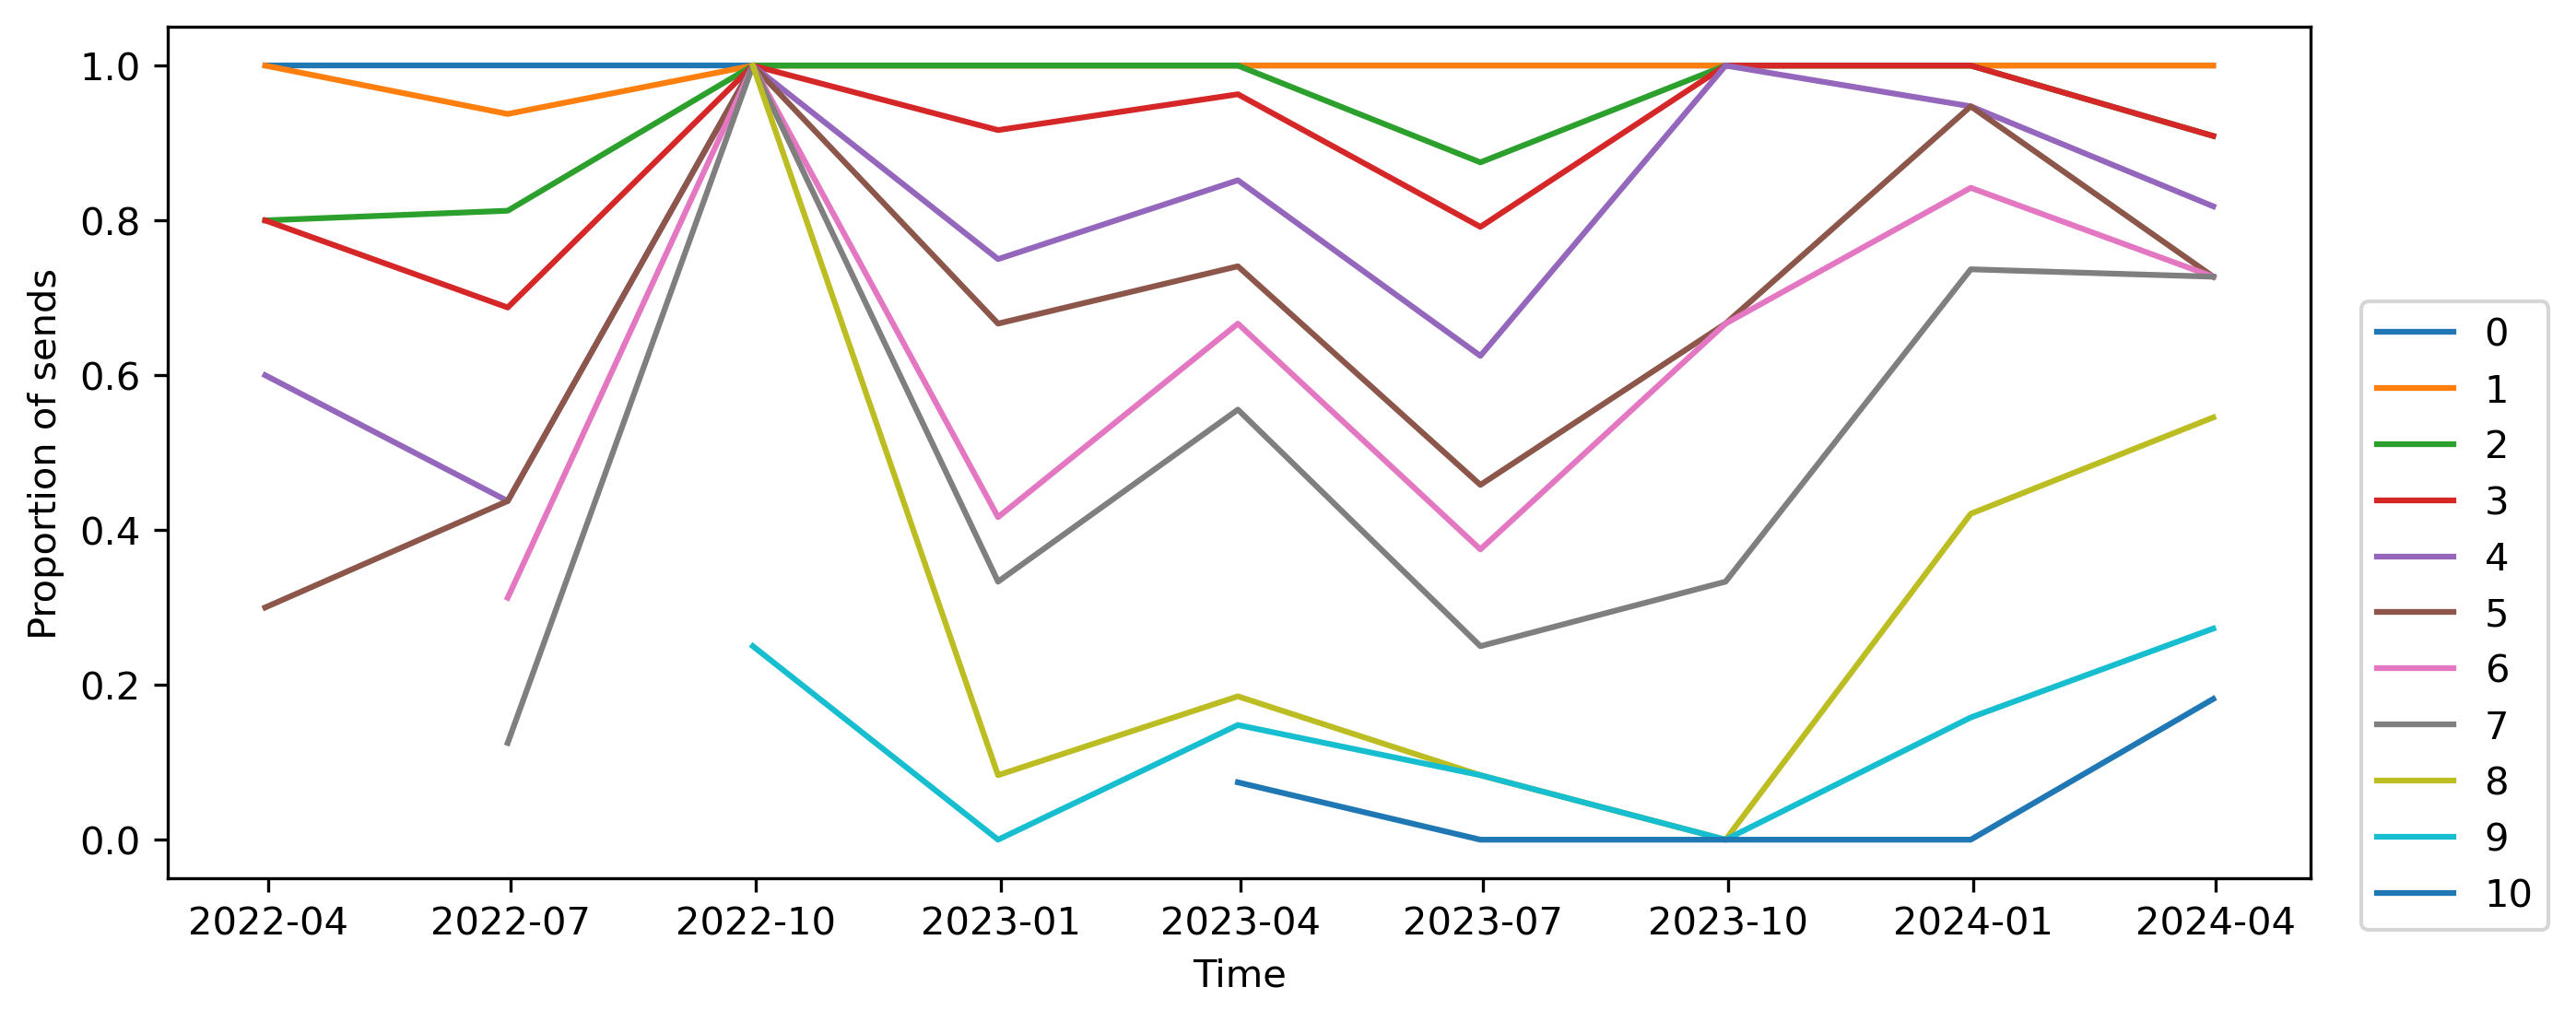

In [45]:
sends = TR[TR['Attempt'] == False]
sends['Time'] = pd.to_datetime(sends['Time'])
sends.set_index('Time', inplace=True)

grade_scale = {'5.7': 1, '5.8': 2, '5.9': 3, '5.10a': 4, '5.10b': 5, '5.10c': 6, '5.10d': 7, '5.11a': 8, '5.11b': 9, '5.11c': 10, '5.11d': 11}
sends['NumericLevel'] = sends['Grade'].map(grade_scale)

plt.figure(figsize=(10, 4), dpi=300)
ax = plt.gca()

for grade, numeric_value in grade_scale.items():
    if grade != 'V6':
        normalized_counts = normalize_counts_by_total(sends, numeric_value)
        line = ax.plot(normalized_counts.index, normalized_counts.values, label=f'{grade_scale[grade]-1}')[0]

plt.legend(bbox_to_anchor=(1.12, 0.7), loc='upper right')
plt.xlabel('Time')
plt.ylabel('Proportion of sends')
plt.show()